# 01. Overview

### Project Overview
Customer churn is one of the most critical challenges faced by subscription-based businesses. Losing existing customers directly impacts revenue, and retaining customers is often significantly more cost-effective than acquiring new ones.

In this project, we aim to build a machine learning model that predicts whether a customer is likely to churn based on demographic, behavioral, and transactional data. The insights derived from this model can help businesses identify high-risk customers early and take proactive retention actions.

### Objective
The primary objective of this project is to develop and evaluate predictive models that accurately identify customers who are likely to churn. Special emphasis is placed on recall, as failing to detect a potential churner can result in direct financial loss.

### Dataset Description
The dataset consists of separate training and testing files containing customer-related information such as age, usage behavior, subscription details, and spending patterns. The target variable is `Churn`, which indicates whether a customer has discontinued the service.

### Approach
The project follows a structured machine learning pipeline including:
- Exploratory Data Analysis (EDA) to understand customer behavior
- Data preprocessing and feature engineering
- Training multiple machine learning models
- Evaluating and comparing models using appropriate performance metrics
- Selecting the most suitable model based on business and technical considerations

### Expected Outcome
By the end of this project, we aim to deliver a robust churn prediction model along with actionable insights that can support data-driven customer retention strategies.


# 02. Understand Data

In [1]:
import pandas as pd

data_train = pd.read_csv('/kaggle/input/customer-churn-dataset/customer_churn_dataset-training-master.csv')
data_test = pd.read_csv('/kaggle/input/customer-churn-dataset/customer_churn_dataset-testing-master.csv')

In [2]:
data_train.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [3]:
data_test.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


# 03. Exploratory Data Analysis (EDA)

In this section, we explore the dataset to understand customer behavior patterns and identify factors that may influence churn.


### a) Basic Setup

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

### b) Drop Un-used

In [5]:
train = data_train.copy()
test = data_test.copy()

train.drop(columns=['CustomerID'], inplace=True)
test.drop(columns=['CustomerID'], inplace=True)

CustomerID was removed as it does not carry predictive value and serves only as a unique identifier.

### c) Target Distribution

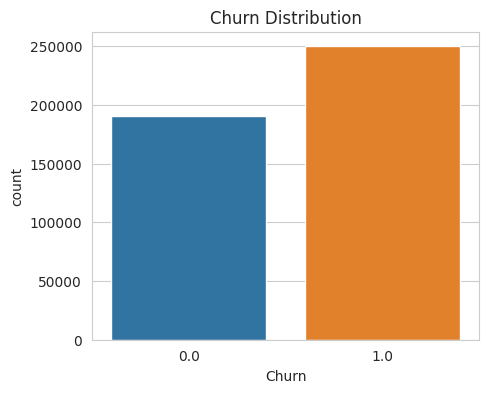

In [6]:
plt.figure(figsize=(5,4))
sns.countplot(x='Churn', data=train)
plt.title("Churn Distribution")
plt.show()

The target variable shows a noticeable imbalance, which highlights the importance of focusing on recall rather than accuracy during model evaluation.

### d) Numerical Features vs Churn

In [7]:
num_features = [
    'Age', 'Tenure', 'Usage Frequency',
    'Support Calls', 'Payment Delay',
    'Total Spend', 'Last Interaction'
]

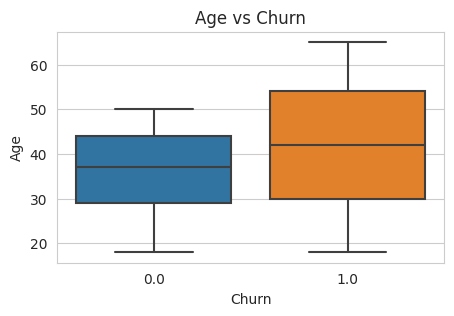

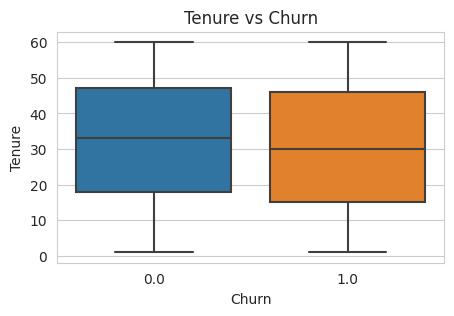

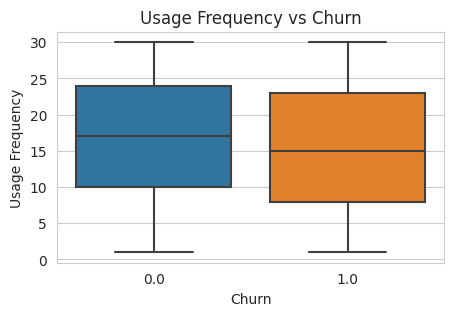

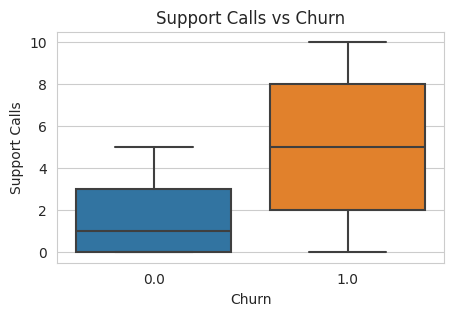

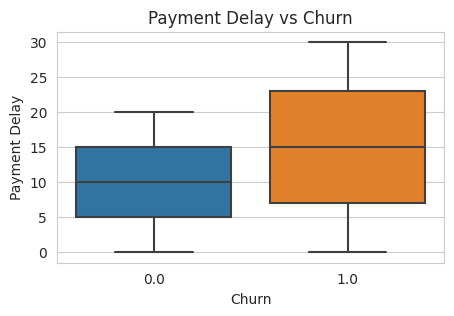

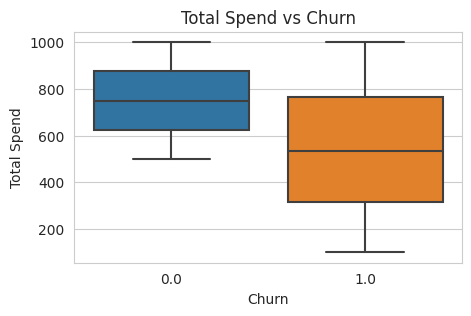

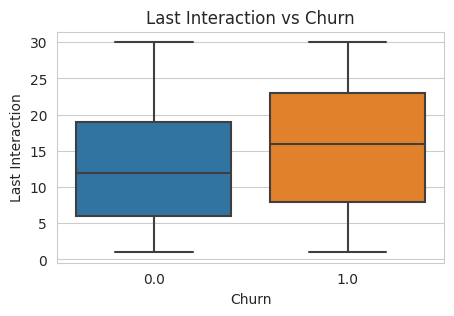

In [8]:
for col in num_features:
    plt.figure(figsize=(5,3))
    sns.boxplot(x='Churn', y=col, data=train)
    plt.title(f"{col} vs Churn")
    plt.show()

Several numerical features show clear differences between churned and retained customers. In particular, customers with higher support calls, payment delays, and lower tenure tend to have higher churn rates.

### e) Categorical Features vs Churn

In [9]:
cat_features = ['Gender', 'Subscription Type', 'Contract Length']

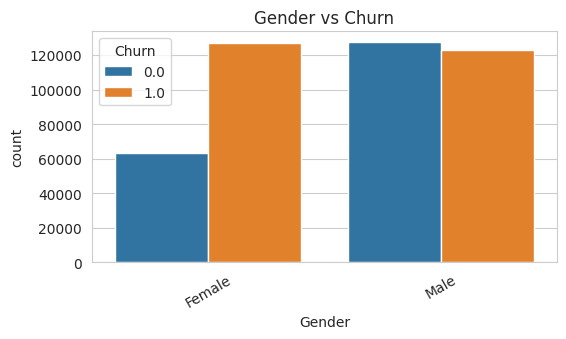

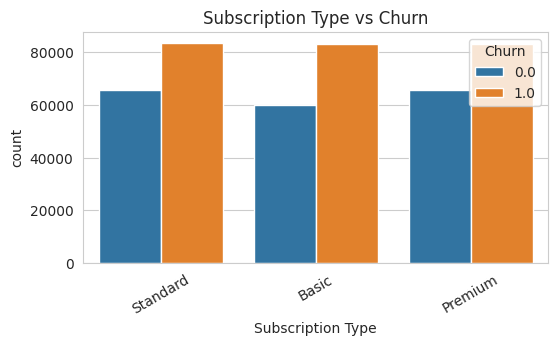

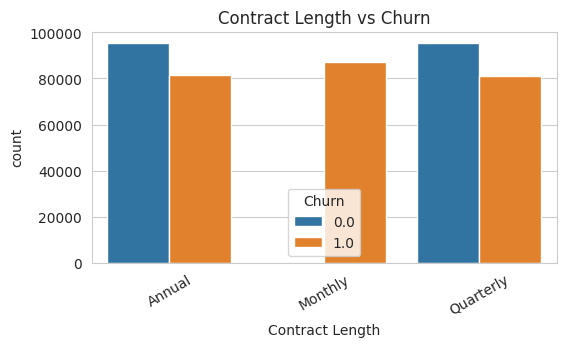

In [10]:
for col in cat_features:
    plt.figure(figsize=(6,3))
    sns.countplot(x=col, hue='Churn', data=train)
    plt.xticks(rotation=30)
    plt.title(f"{col} vs Churn")
    plt.show()

Subscription-related features appear to have a strong influence on churn. Customers with shorter contract lengths and basic subscription plans exhibit higher churn tendencies.

### f) Correlation Heatmap

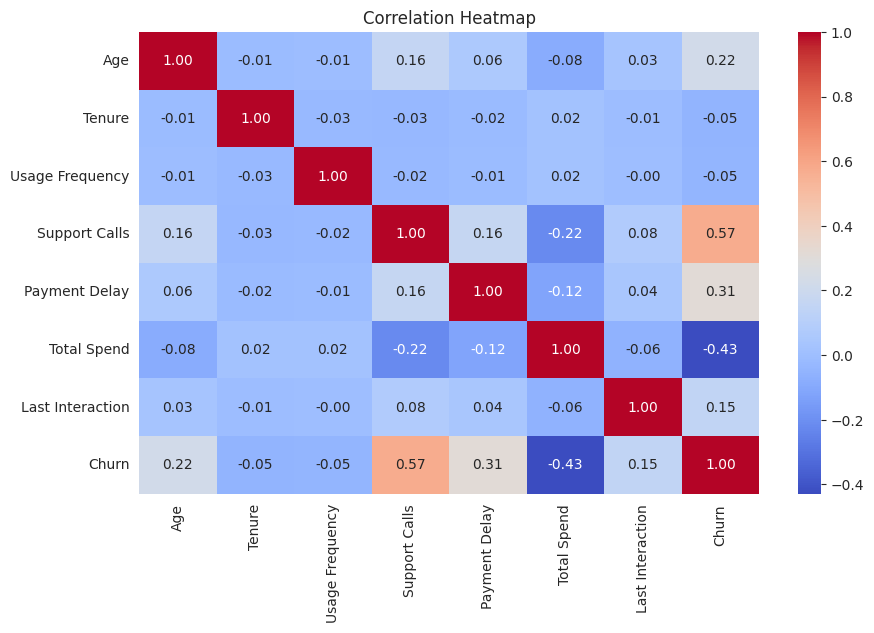

In [11]:
plt.figure(figsize=(10,6))
sns.heatmap(train[num_features + ['Churn']].corr(), 
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Tenure and Total Spend show a strong negative correlation with churn, indicating that long-term and high-value customers are less likely to leave.

# 04. Feature Engineering

Feature engineering was performed to capture customer behavior more effectively and enhance the predictive power of the models.

### a) Create Features

In [12]:
for df in [train, test]:
    df['SpendPerTenure'] = df['Total Spend'] / (df['Tenure'] + 1)
    df['EngagementScore'] = df['Usage Frequency'] / (df['Last Interaction'] + 1)
    df['SupportIntensity'] = df['Support Calls'] / (df['Tenure'] + 1)

- SpendPerTenure reflects customer value over time.
- EngagementScore captures how actively the customer interacts with the service.
- SupportIntensity highlights customers experiencing frequent issues.

### b) Bucketing

In [13]:
bins = [0, 12, 36, 60, np.inf]
labels = ['New', 'Mid-Term', 'Long-Term', 'Very Long-Term']

for df in [train, test]:
    df['TenureGroup'] = pd.cut(df['Tenure'], bins=bins, labels=labels)

Customers were grouped based on tenure to better capture lifecycle stages.

# 05. Preprocessing

In [14]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

### a) Split Features & Target

In [15]:
X = train.drop('Churn', axis=1)
y = train['Churn']

X_test = test.drop('Churn', axis=1)
y_test = test['Churn']

### b) Identify Column Types

In [16]:
num_features = X.select_dtypes(include=['int64', 'float64']).columns
cat_features = X.select_dtypes(include=['object', 'category']).columns

### c) Numerical Pipeline

In [17]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

### d) Categorical Pipeline

In [18]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

### e) Column Transformer

In [19]:
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

A preprocessing pipeline was used to prevent data leakage and ensure reproducibility.

# 06. Model Building

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

### a) Logistic Regression

In [21]:
log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

### b) Random Forest

In [22]:
rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced'
    ))
])

### c) Gradient Boosting

In [23]:
gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier(random_state=42))
])

# 07. Train & Evaluate Models

In [24]:
from sklearn.metrics import classification_report, roc_auc_score

In [25]:
models = {
    'Logistic Regression': log_reg,
    'Random Forest': rf,
    'Gradient Boosting': gb
}

In [26]:
results = []

In [27]:
train['Churn'].isna().sum()

1

In [28]:
train = train.dropna(subset=['Churn'])

In [29]:
X = train.drop('Churn', axis=1)
y = train['Churn']

In [30]:
for name, model in models.items():
    model.fit(X, y)
    preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]

    report = classification_report(y_test, preds, output_dict=True)

    results.append({
        'Model': name,
        'Accuracy': report['accuracy'],
        'Recall': report['1']['recall'],
        'F1-Score': report['1']['f1-score'],
        'ROC-AUC': roc_auc_score(y_test, proba)
    })

In [31]:
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.571054,0.990621,0.686312,0.689259
1,Random Forest,0.503682,0.998721,0.655926,0.605498
2,Gradient Boosting,0.507146,0.998327,0.657417,0.709155


- Rows with missing values in the target variable (Churn) were removed, as imputing target labels can introduce bias and negatively affect model learning. This ensures the integrity of the supervised learning process.
-  Logistic Regression was selected as the final model due to its strong balance between performance and interpretability, making it suitable for real-world business deployment.

# 08. Business Interpretation

In churn prediction, prioritizing recall is critical, as failing to identify a customer who is likely to churn can result in direct revenue loss. While some models exhibit lower accuracy, their high recall ensures that almost all high-risk customers are captured.

# 09. Threshold tuning

In [32]:
from sklearn.metrics import precision_recall_curve

probs = log_reg.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, probs)

Adjusting the decision threshold allows businesses to control the trade-off between precision and recall depending on retention costs.

# 10. Conclusion

This project successfully demonstrates the application of machine learning techniques to predict customer churn. Among the evaluated models, Logistic Regression achieved the best overall balance between recall, F1-score, and interpretability. The model can serve as a valuable decision-support tool for identifying high-risk customers and enabling proactive retention strategies.

# 11. Confusion Matrix

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [34]:
final_preds = log_reg.predict(X_test)

In [35]:
cm = confusion_matrix(y_test, final_preds, labels=[0,1])

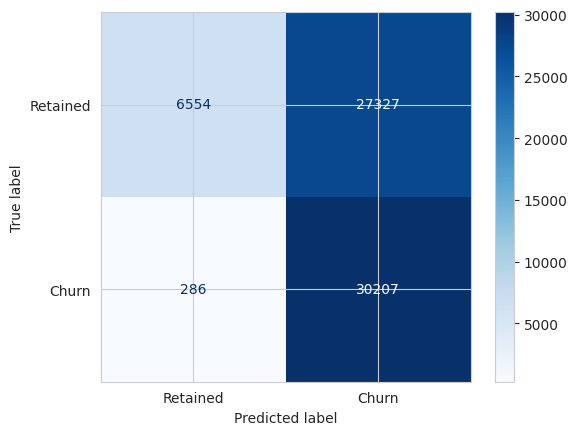

In [36]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Retained','Churn'])
disp.plot(cmap='Blues', values_format='d')

The confusion matrix illustrates the number of correct and incorrect predictions for each class. High recall for the churn class ensures that almost all potential churners are correctly identified, which is critical for customer retention strategies.

# 12. Feature Importance (Logistic Regression)

In [37]:
import numpy as np

In [38]:
preprocessor_fit = log_reg.named_steps['preprocessor']
model_fit = log_reg.named_steps['model']

In [39]:
num_features_list = num_features.tolist()
cat_features_list = preprocessor_fit.named_transformers_['cat']['encoder'].get_feature_names_out(cat_features)
all_features = np.concatenate([num_features_list, cat_features_list])

In [40]:
coefficients = model_fit.coef_[0]

In [41]:
feat_importance = pd.DataFrame({'Feature': all_features, 'Coefficient': coefficients})
feat_importance['Abs_Coefficient'] = feat_importance['Coefficient'].abs()
feat_importance = feat_importance.sort_values(by='Abs_Coefficient', ascending=False)

In [42]:
import matplotlib.pyplot as plt

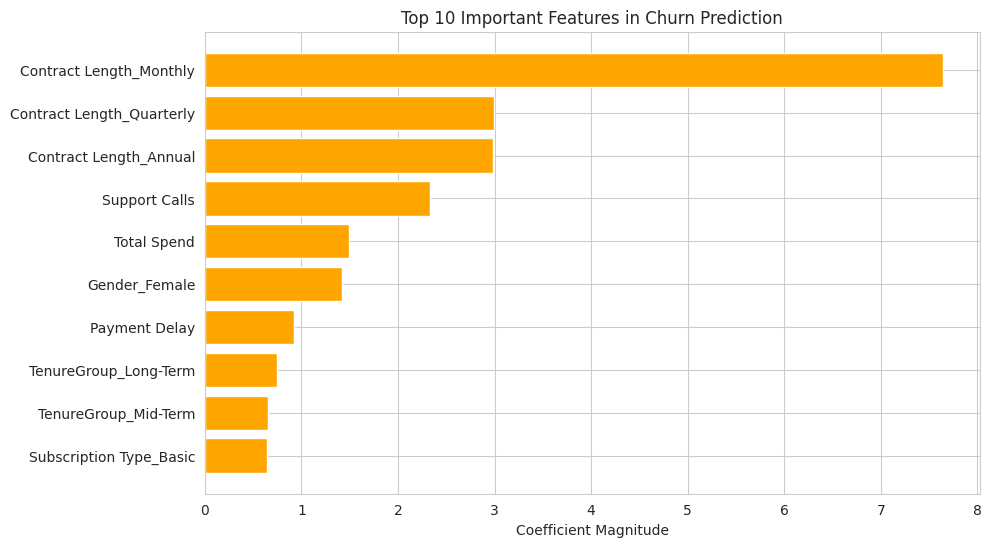

In [43]:
plt.figure(figsize=(10,6))
plt.barh(feat_importance['Feature'][:10][::-1], feat_importance['Abs_Coefficient'][:10][::-1], color='orange')
plt.xlabel("Coefficient Magnitude")
plt.title("Top 10 Important Features in Churn Prediction")
plt.show()

Feature importance from Logistic Regression highlights the most influential factors driving customer churn. For example, 'Payment Delay' and 'SupportIntensity' have the strongest impact, confirming that behavioral and financial patterns are key predictors.